# Evaluate the influence of clouds with radiative index

In [60]:
import json
import pandas as pd
import numpy as np
import gc
from sklearn import linear_model
from sklearn.metrics import accuracy_score,r2_score
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pysolar.solar as psl
from datetime import datetime, timezone, timedelta
import pytz

from influxdb import InfluxDBClient, DataFrameClient
import warnings
warnings.filterwarnings('ignore')

In [2]:
titlefont={'size':15,'weight':'bold'}
axisfont ={'size':12,'weight':'bold'}

In [3]:
config_file = "/Users/privateUser/Project/src/config.json"
with open(config_file,'r') as f:
    config = json.load(f)

connection = config['influxDB_Power']['connection']['external']
#connection = config['influxDB_Power']['connection']['internal']

clientDF = DataFrameClient(**connection)

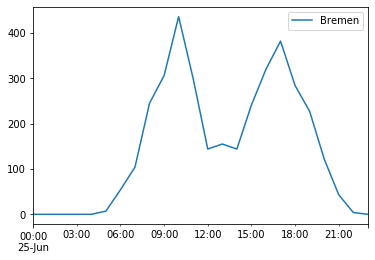

In [4]:
res = clientDF.query('''select "Bremen" from climate..Global_radiation 
                        where time >= \'2019-06-25 00:00:00\' and time < \'2019-06-26 00:00:00\'
                        ''')
radquery = res['Global_radiation']
radquery.plot()

In [5]:
res = clientDF.query('''show field keys from climate..Global_radiation''')


In [6]:
wackodot = 'Ø'
ignore = ['year','month','weekday','holiday','hour','minute',wackodot]
ignore

['year', 'month', 'weekday', 'holiday', 'hour', 'minute', 'Ø']

In [7]:
cities=[ v['fieldKey'] for v in list(res)[0] if v['fieldKey'] not in ignore]
cities

['Bremen',
 'Chemnitz',
 'Fichtelberg',
 'Furstenzell',
 'Gorlitz',
 'Hamburg',
 'Hohenpeissenberg',
 'Konstanz',
 'Lindenberg',
 'Norderney',
 'Potsdam',
 'Rostock',
 'Saarbrucken',
 'Schleswig',
 'Seehausen',
 'Trier',
 'Wuerzburg']

---
# Begin productive queries
---

In [8]:
startTime = "2019-06-20 14:00:00"
endTime   = "2019-07-01 00:00:00"
#database = "climate..Global_radiation"
database = "climate..Diffuse_radiation"

In [9]:
citiesCSV = ",".join([ f'"{ct}"' for ct in cities])
queryStatement = f"""\
 SELECT {citiesCSV} FROM {database} \
                    WHERE time >= '{startTime}' \
                    AND time <= '{endTime}'"""
print(queryStatement)

 SELECT "Bremen","Chemnitz","Fichtelberg","Furstenzell","Gorlitz","Hamburg","Hohenpeissenberg","Konstanz","Lindenberg","Norderney","Potsdam","Rostock","Saarbrucken","Schleswig","Seehausen","Trier","Wuerzburg" FROM climate..Diffuse_radiation                     WHERE time >= '2019-06-20 14:00:00'                     AND time <= '2019-07-01 00:00:00'


In [10]:
res = clientDF.query(queryStatement)
#res

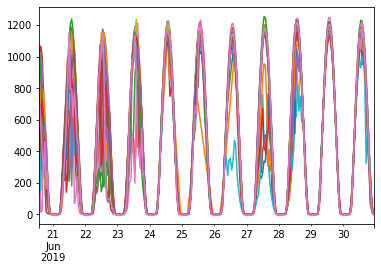

In [11]:
radquery = res[list(res.keys())[0]]
radquery.interpolate(limit_direction='both',inplace=True)
radquery.plot(legend=False)


---
# Predict the same radiative flux using the coordinates & pysolar
---

In [12]:
weatherFile = "/Users/privateUser/Project/data/WeatherData/curr_20190701_002505.json"
with open(weatherFile,'r') as f:
    currWeather = json.load(f)
#currWeather

In [13]:
def getRadiativeIndex(city,date):
    longitude = currWeather[city]['coord']['lon']
    latitude  = currWeather[city]['coord']['lat']
    altitude_deg = psl.get_altitude(latitude,longitude,date)
    return psl.radiation.get_radiation_direct(date,altitude_deg)

In [14]:
radcalc = pd.DataFrame(index = radquery.index)

In [15]:
for ct in cities:
    radcalc[ct + '_pred'] = radcalc.index.map(lambda x: getRadiativeIndex(ct,x + timedelta(hours=-2)))

In [16]:
radcalc

,Bremen_pred,Chemnitz_pred,Fichtelberg_pred,Furstenzell_pred,Gorlitz_pred,Hamburg_pred,Hohenpeissenberg_pred,Konstanz_pred,Lindenberg_pred,Norderney_pred,Potsdam_pred,Rostock_pred,Saarbrucken_pred,Schleswig_pred,Seehausen_pred,Trier_pred,Wuerzburg_pred
2019-06-20 14:00:00+00:00,855.172101,857.718974,859.708180,861.412170,855.981463,853.787536,863.683730,864.625097,859.463560,854.402275,854.721076,851.757202,862.796824,851.902312,854.391278,861.994046,860.886003
2019-06-20 15:00:00+00:00,845.403964,845.010094,847.684088,848.233854,841.842360,843.272897,852.087253,854.271958,847.882409,845.739397,842.055547,839.869061,853.989201,841.736762,842.661203,853.449022,850.154116
2019-06-20 16:00:00+00:00,824.730787,820.272922,823.775347,822.619524,815.209736,821.691000,828.532641,832.349601,824.591085,826.516133,817.545177,816.565660,834.198986,820.696766,819.436829,834.036073,827.930229
2019-06-20 17:00:00+00:00,789.164998,778.223123,782.827552,778.741586,770.308330,784.886313,787.716347,794.007817,784.639754,793.139593,776.164404,777.336920,799.296930,784.856348,780.084687,799.768131,789.498054
2019-06-20 18:00:00+00:00,730.561891,707.823299,713.988358,704.108150,695.085267,724.428634,718.226536,728.808813,717.643662,738.285592,707.600062,713.105805,740.507090,726.327193,715.150624,742.204887,724.913515
2019-06-20 19:00:00+00:00,631.956537,584.755109,593.139578,569.995884,562.862240,622.822095,593.892633,613.036758,600.715478,646.928080,589.746804,605.072997,638.584022,629.027240,604.657976,643.010021,612.227600
2019-06-20 20:00:00+00:00,456.023650,352.653218,363.195062,306.695435,312.973141,441.939697,349.723596,387.714301,380.011774,486.604763,373.191933,412.824488,447.607194,458.740635,404.366753,458.997297,399.250293
2019-06-20 21:00:00+00:00,140.936739,10.715370,12.340790,0.033990,1.363707,124.304326,2.231596,15.745208,24.139763,197.122752,32.240920,89.396472,90.824918,159.994404,67.511146,112.947087,36.960268
2019-06-20 22:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-20 23:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


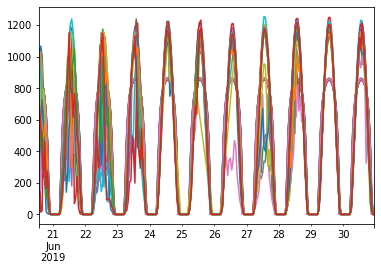

In [17]:
radall= radcalc.join(radquery,how='outer')
radall.plot(legend=False)

---
# Query the cloudiness 
- based upon city, correlate against the reduction in solar index
---

In [18]:
citiesCSV = ",".join([ f'currentWeather.."wc-{ct}"' for ct in cities])
queryStatement = f"""\
 SELECT "clouds" FROM {citiesCSV} \
                    WHERE time >= '{startTime}' \
                    AND time <= '{endTime}'"""
print(queryStatement)

 SELECT "clouds" FROM currentWeather.."wc-Bremen",currentWeather.."wc-Chemnitz",currentWeather.."wc-Fichtelberg",currentWeather.."wc-Furstenzell",currentWeather.."wc-Gorlitz",currentWeather.."wc-Hamburg",currentWeather.."wc-Hohenpeissenberg",currentWeather.."wc-Konstanz",currentWeather.."wc-Lindenberg",currentWeather.."wc-Norderney",currentWeather.."wc-Potsdam",currentWeather.."wc-Rostock",currentWeather.."wc-Saarbrucken",currentWeather.."wc-Schleswig",currentWeather.."wc-Seehausen",currentWeather.."wc-Trier",currentWeather.."wc-Wuerzburg"                     WHERE time >= '2019-06-20 14:00:00'                     AND time <= '2019-07-01 00:00:00'


In [19]:
#queryStatement = 'SELECT "clouds" FROM currentWeather.."wc-Bremen"'
res = clientDF.query(queryStatement)


In [20]:
cloudsbase = pd.DataFrame(index=radall.index)
for ct in cities:
    cloudsbase = cloudsbase.join(pd.DataFrame({ ct:res['wc-' + ct].clouds}),how='outer')

In [21]:
cloudsall = cloudsbase.interpolate(limit_direction='both').reindex(radall.index)
cloudsall.iloc[0:10]

,Bremen,Chemnitz,Fichtelberg,Furstenzell,Gorlitz,Hamburg,Hohenpeissenberg,Konstanz,Lindenberg,Norderney,Potsdam,Rostock,Saarbrucken,Schleswig,Seehausen,Trier,Wuerzburg
2019-06-20 14:00:00+00:00,40.0,20.0,20.000000,94.0,73.0,75.000000,100.0,40.000,40.000000,75.0,20.0,75.0,40.000000,75.0,66.0,75.000000,75.0
2019-06-20 15:00:00+00:00,40.0,20.0,37.894737,94.0,73.0,75.000000,100.0,40.000,26.000000,75.0,20.0,75.0,40.000000,75.0,66.0,20.000000,75.0
2019-06-20 16:00:00+00:00,75.0,20.0,40.000000,89.0,75.0,59.090909,100.0,50.500,37.647059,75.0,20.0,75.0,28.275862,75.0,38.0,75.000000,75.0
2019-06-20 17:00:00+00:00,40.0,0.0,0.000000,89.0,75.0,33.750000,100.0,75.000,0.000000,75.0,20.0,75.0,34.000000,40.0,38.0,40.000000,75.0
2019-06-20 18:00:00+00:00,20.0,20.0,0.000000,89.0,75.0,40.000000,100.0,20.000,0.000000,75.0,20.0,75.0,20.000000,97.0,38.0,75.000000,75.0
2019-06-20 19:00:00+00:00,20.0,20.0,0.000000,94.0,38.0,20.000000,99.0,0.000,0.000000,75.0,20.0,40.0,20.000000,93.0,49.0,40.000000,40.0
2019-06-20 20:00:00+00:00,20.0,40.0,75.000000,94.0,38.0,20.000000,99.0,40.000,0.000000,75.0,20.0,20.0,20.000000,93.0,49.0,40.000000,40.0
2019-06-20 21:00:00+00:00,40.0,65.0,97.000000,56.0,55.0,20.000000,82.0,40.375,99.000000,56.0,20.0,20.0,20.000000,68.8,74.0,38.333333,20.0
2019-06-20 22:00:00+00:00,40.0,99.0,34.000000,100.0,9.0,40.000000,0.0,37.000,33.000000,13.0,40.0,20.0,20.000000,99.0,100.0,0.000000,40.0
2019-06-20 23:00:00+00:00,75.0,99.0,34.000000,100.0,9.0,40.000000,0.0,37.000,33.000000,13.0,20.0,40.0,20.000000,99.0,100.0,20.000000,20.0


---
# Correlate cloudiness with observed vs. predicted radiation
---

In [23]:
radcloud_macro = pd.DataFrame(index=radall.index)
radcloud_macro['mean_rad_pred'] = 0
radcloud_macro['mean_rad_meas'] = 0

radcloud_micro = pd.DataFrame(columns=['rad_pred','rad_meas'])

for ct in cities:
    rad_pred = (((100-cloudsall[ct])/100)*0.8 + 0.2)*radall[ct + '_pred']
    rad_meas = radall[ct]
    radcloud_macro['mean_rad_pred'] += rad_pred  # macro average
    radcloud_macro['mean_rad_meas'] += rad_meas
    
    radtemp = pd.DataFrame({'rad_meas':rad_meas,'rad_pred':rad_pred})
    radcloud_micro = radcloud_micro.append(radtemp)
    
    
radcloud_macro['mean_rad_pred'] /= len(cities)
radcloud_macro['mean_rad_meas'] /= len(cities)
radcloud_micro.reset_index()
radcloud_micro.iloc[0:10]

,rad_meas,rad_pred
2019-06-20 14:00:00+00:00,644,581.517028
2019-06-20 15:00:00+00:00,864,574.874695
2019-06-20 16:00:00+00:00,612,329.892315
2019-06-20 17:00:00+00:00,382,536.632199
2019-06-20 18:00:00+00:00,562,613.671988
2019-06-20 19:00:00+00:00,310,530.843491
2019-06-20 20:00:00+00:00,76,383.059866
2019-06-20 21:00:00+00:00,7,95.836982
2019-06-20 22:00:00+00:00,4,0.000000
2019-06-20 23:00:00+00:00,0,0.000000


In [24]:
# for the generalized calcuation
# to prevent bottoming out:  radPredict[ct] = (((100-cloudsall[ct])/100)*0.8 + 0.2)*radcalc[ct]
radPredict = pd.DataFrame(index=radall.index)
for ct in cities:
    #radPredict[ct] = (1-cloudsall[ct]/100)*radall[ct + '_pred']
    radPredict[ct] = (((100-cloudsall[ct])/100)*0.8 + 0.2)*radcalc[ct + '_pred']

In [25]:
radPredict['morning'] = (radPredict.index.hour <= 12 )*1

In [26]:
radPredict

,Bremen,Chemnitz,Fichtelberg,Furstenzell,Gorlitz,Hamburg,Hohenpeissenberg,Konstanz,Lindenberg,Norderney,Potsdam,Rostock,Saarbrucken,Schleswig,Seehausen,Trier,Wuerzburg,morning
2019-06-20 14:00:00+00:00,581.517028,720.483938,722.154871,213.630218,356.088289,341.515014,172.736746,587.945066,584.435221,341.760910,717.965704,340.702881,586.701840,340.760925,403.272683,344.797619,344.354401,0
2019-06-20 15:00:00+00:00,574.874695,709.808479,590.701964,210.361996,350.206422,337.309159,170.417451,580.904931,671.522868,338.295759,707.326660,335.947625,580.712656,336.694705,397.736088,716.897178,340.061646,0
2019-06-20 16:00:00+00:00,329.892315,689.029254,560.167236,236.914423,326.083894,433.255255,165.706528,496.080362,576.243652,330.606453,686.737949,326.626264,645.497422,328.278707,570.328033,333.614429,331.172091,0
2019-06-20 17:00:00+00:00,536.632199,778.223123,782.827552,224.277577,308.123332,572.967008,157.543269,317.603127,784.639754,317.255837,651.978099,310.934768,581.888165,533.702316,542.938942,543.842329,315.799222,0
2019-06-20 18:00:00+00:00,613.671988,594.571571,713.988358,202.783147,278.034107,492.611471,143.645307,612.199403,717.643662,295.314237,594.384052,285.242322,622.025955,162.697291,497.744835,296.881955,289.965406,0
2019-06-20 19:00:00+00:00,530.843491,491.194292,593.139578,141.358979,391.752119,523.170559,123.529668,613.036758,600.715478,258.771232,495.387316,411.449638,536.410579,161.030973,367.632050,437.246814,416.314768,0
2019-06-20 20:00:00+00:00,383.059866,239.804188,145.278025,76.060468,217.829306,371.229345,72.742508,263.645724,380.011774,194.641905,313.481224,346.772570,375.990043,117.437603,245.854986,312.118162,271.490199,0
2019-06-20 21:00:00+00:00,95.836982,5.143378,2.764337,0.018762,0.763676,104.415634,0.767669,10.659506,5.021071,108.811759,27.082373,75.093036,76.292932,71.933484,27.544547,78.309980,31.046625,0
2019-06-20 22:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2019-06-20 23:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


Text(0, 0.5, 'Mean Radiative Flux Measured (W/m^2)')

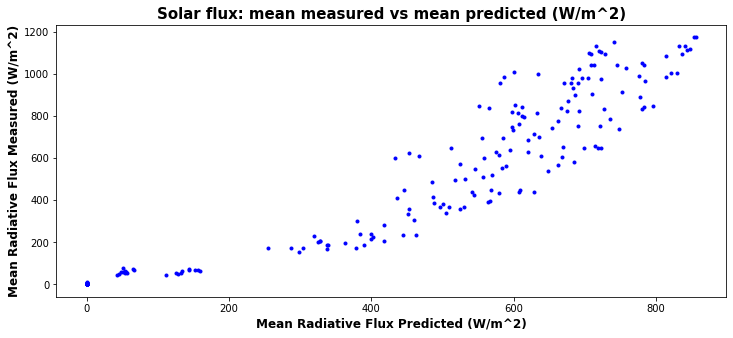

In [27]:

#radcloud_macro.plot.scatter(x='mean_rad_pred', y='mean_rad_meas')
plt.figure(figsize=(12,5))
plt.plot(radcloud_macro.mean_rad_pred,radcloud_macro.mean_rad_meas,'b.')
plt.title("Solar flux: mean measured vs mean predicted (W/m^2)",fontdict=titlefont)
plt.xlabel("Mean Radiative Flux Predicted (W/m^2)", fontdict=axisfont)
plt.ylabel("Mean Radiative Flux Measured (W/m^2)",fontdict=axisfont)

---
- try with micro averaging
---

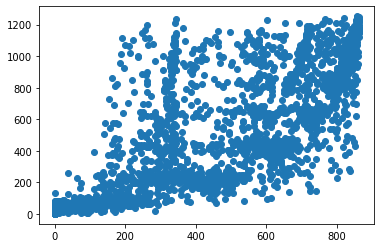

In [28]:
plt.scatter(radcloud_micro.rad_pred,radcloud_micro.rad_meas)

---
## Regression model
---

In [29]:
reg= linear_model.LinearRegression()

In [30]:
reg.fit(X=radcloud_macro[['mean_rad_pred']],y=radcloud_macro['mean_rad_meas'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
print(f"coefficient={reg.coef_[0]}\nintercept={reg.intercept_}")

coefficient=1.2163648353186125
intercept=-39.44735922506817


Text(0, 0.5, 'Mean Radiative Flux measured (W/m^2)')

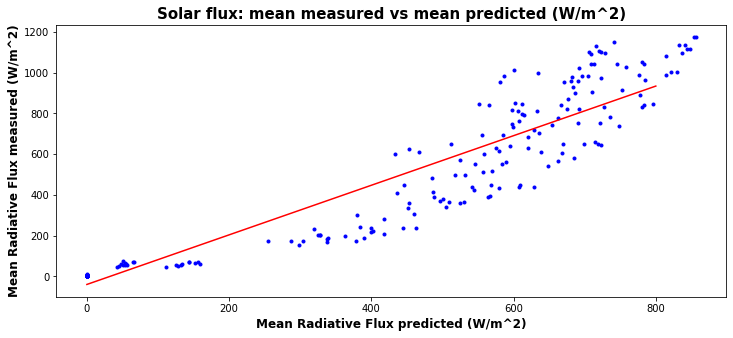

In [32]:
x = radcloud_macro.mean_rad_pred
y = radcloud_macro.mean_rad_meas
X=np.array([0,800]).reshape(-1,1)
yhat=reg.predict(X)

plt.figure(figsize=(12,5))
plt.plot(x,y,'b.')
plt.plot(X,yhat,'r-')
plt.title("Solar flux: mean measured vs mean predicted (W/m^2)",fontdict=titlefont)
plt.xlabel("Mean Radiative Flux predicted (W/m^2)", fontdict=axisfont)
plt.ylabel("Mean Radiative Flux measured (W/m^2)",fontdict=axisfont)


---
New try, assume that curve is a power function


In [33]:
# assume that the curve is an approximate power function
def func(x,a,b):
    func = a*x**b
    return func

In [34]:
popt, pcov = curve_fit(func, x, y)

In [35]:
x_pred = np.linspace(x.min(),x.max(),100)
y_pred = func(x_pred,*popt)

Text(0, 0.5, 'Mean Radiative Flux Measured (W/m^2)')

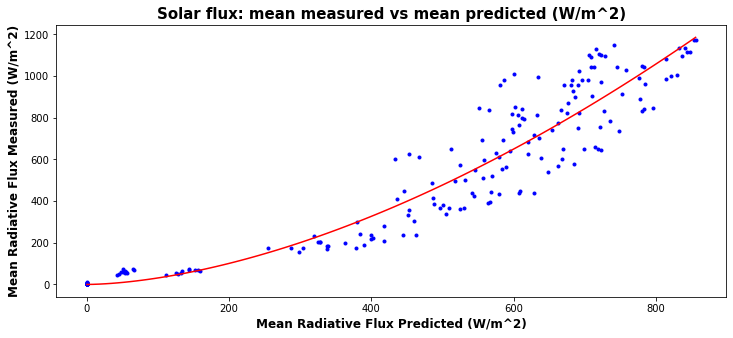

In [36]:
plt.figure(figsize=(12,5))
plt.plot(x,y,'b.')
plt.plot(x_pred,y_pred,'r-')
plt.title("Solar flux: mean measured vs mean predicted (W/m^2)",fontdict=titlefont)
plt.xlabel("Mean Radiative Flux Predicted (W/m^2)", fontdict=axisfont)
plt.ylabel("Mean Radiative Flux Measured (W/m^2)",fontdict=axisfont)

In [37]:
print(rf"resulting function:  Qactual(q_predict) = {popt[0]} * q_predict ** {popt[1]}")

resulting function:  Qactual(q_predict) = 0.012798835045890949 * q_predict ** 1.6937099737404364


---
# Correlate solar flux with power production
---

In [38]:
database = 'power..solar_wind'

In [39]:

# select the measurements from the 'power' database for "Solar...".  Don't trust the average that they supply
res = clientDF.query(f'''show field keys from {database}''')

In [40]:
sources = [ v['fieldKey'] for v in list(res)[0] if v['fieldKey'].startswith("Solar")]
sources

['Solar 50Hertz', 'Solar Amprion', 'Solar Tennet', 'Solar Transnet BW']

In [41]:
sourcesCSV = ",".join([ f'"{sr}"' for sr in sources])
queryStatement = f"""\
 SELECT {sourcesCSV} FROM {database} \
                    WHERE time >= '{startTime}' \
                    AND time <= '{endTime}'"""
print(queryStatement)

 SELECT "Solar 50Hertz","Solar Amprion","Solar Tennet","Solar Transnet BW" FROM power..solar_wind                     WHERE time >= '2019-06-20 14:00:00'                     AND time <= '2019-07-01 00:00:00'


In [42]:
res = clientDF.query(queryStatement)

In [43]:
solarPower = None
gc.collect()
solarPower = res[list(res.keys())[0]]
solarPower.iloc[0:10]

,Solar 50Hertz,Solar Amprion,Solar Tennet,Solar Transnet BW
2019-06-20 14:00:00+00:00,5.378,3.817,7.461,1.897
2019-06-20 14:15:00+00:00,5.322,3.716,7.228,1.833
2019-06-20 14:30:00+00:00,5.228,3.505,7.140,1.711
2019-06-20 14:45:00+00:00,5.248,3.415,6.824,1.572
2019-06-20 15:00:00+00:00,5.054,3.276,6.623,1.438
2019-06-20 15:15:00+00:00,4.865,2.972,6.404,1.398
2019-06-20 15:30:00+00:00,4.694,2.850,6.155,1.409
2019-06-20 15:45:00+00:00,4.503,2.475,5.835,1.331
2019-06-20 16:00:00+00:00,4.102,2.394,5.392,1.309
2019-06-20 16:15:00+00:00,3.777,2.337,4.774,1.417


In [44]:
solarPower.columns

Index(['Solar 50Hertz', 'Solar Amprion', 'Solar Tennet', 'Solar Transnet BW'], dtype='object')

In [45]:
solarPower['Solar_total'] = solarPower.sum(axis=1)
solarPower.iloc[0:10]

,Solar 50Hertz,Solar Amprion,Solar Tennet,Solar Transnet BW,Solar_total
2019-06-20 14:00:00+00:00,5.378,3.817,7.461,1.897,18.553
2019-06-20 14:15:00+00:00,5.322,3.716,7.228,1.833,18.099
2019-06-20 14:30:00+00:00,5.228,3.505,7.140,1.711,17.584
2019-06-20 14:45:00+00:00,5.248,3.415,6.824,1.572,17.059
2019-06-20 15:00:00+00:00,5.054,3.276,6.623,1.438,16.391
2019-06-20 15:15:00+00:00,4.865,2.972,6.404,1.398,15.639
2019-06-20 15:30:00+00:00,4.694,2.850,6.155,1.409,15.108
2019-06-20 15:45:00+00:00,4.503,2.475,5.835,1.331,14.144
2019-06-20 16:00:00+00:00,4.102,2.394,5.392,1.309,13.197
2019-06-20 16:15:00+00:00,3.777,2.337,4.774,1.417,12.305


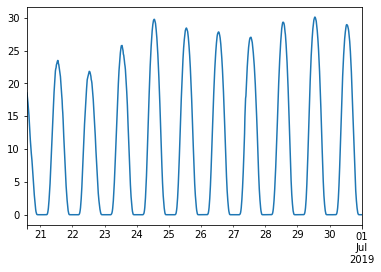

In [46]:
solarPower.Solar_total.plot()

In [47]:
rad_solarpower = pd.DataFrame({"solar":solarPower.Solar_total})
rad_solarpower.iloc[0:10]

,solar
2019-06-20 14:00:00+00:00,18.553
2019-06-20 14:15:00+00:00,18.099
2019-06-20 14:30:00+00:00,17.584
2019-06-20 14:45:00+00:00,17.059
2019-06-20 15:00:00+00:00,16.391
2019-06-20 15:15:00+00:00,15.639
2019-06-20 15:30:00+00:00,15.108
2019-06-20 15:45:00+00:00,14.144
2019-06-20 16:00:00+00:00,13.197
2019-06-20 16:15:00+00:00,12.305


In [48]:
#citiesCSV = ",".join([ f'currentWeather.."wc-{ct}"' for ct in cities])
#queryStatement = f"""\
# SELECT "clouds" FROM {citiesCSV} \
#                    WHERE time >= '{startTime}' \
#                    AND time <= '{endTime}'"""
##print(queryStatement)
#res = clientDF.query(queryStatement)
#
#cloudsbase = pd.DataFrame()
#for ct in cities:
#    cloudsbase = cloudsbase.join(pd.DataFrame({ ct:res['wc-' + ct].clouds}),how='outer')
#    
#cloudsall= cloudsbase.interpolate(limit_direction='both').reindex(radall.index)

In [49]:
rad_solarpower = rad_solarpower.join(radcloud_macro,how='outer').interpolate(limit_direction='both')

Text(0, 0.5, 'Measured Solar Power (MW)')

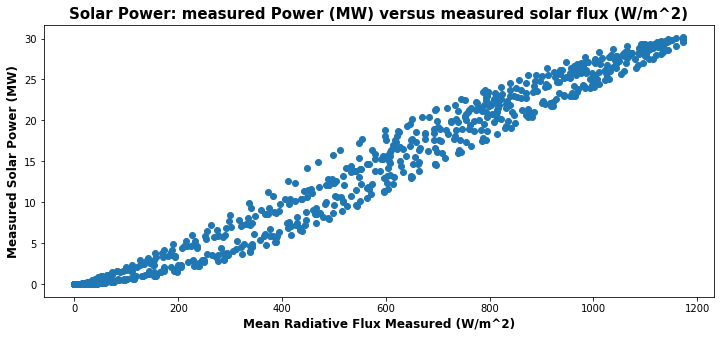

In [50]:
# explanation:  the actual solar power is reflected by the measured solar radiation.  
#  the hystersis shape of the curve is due to the solar panels being in a fixed position and the
#  received radition would be due to the angle of the sun (where as diffuse radiation is uni-direction)
plt.figure(figsize=(12,5))
plt.scatter(rad_solarpower.mean_rad_meas,rad_solarpower.solar)
plt.title("Solar Power: measured Power (MW) versus measured solar flux (W/m^2)",fontdict=titlefont)
plt.xlabel("Mean Radiative Flux Measured (W/m^2)",fontdict=axisfont)
plt.ylabel("Measured Solar Power (MW)", fontdict=axisfont)


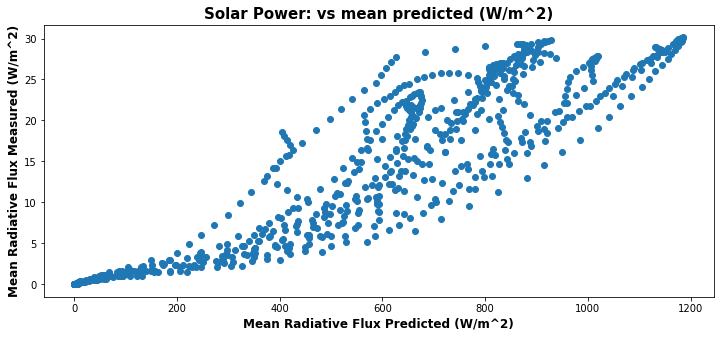

In [51]:
# conversly, predicted radiative flux is an approximate value for the solar power produced
plt.figure(figsize=(12,5))
plt.scatter(func(rad_solarpower.mean_rad_pred,*popt),rad_solarpower.solar)
plt.title("Solar Power: vs mean predicted (W/m^2)",fontdict=titlefont)
plt.xlabel("Mean Radiative Flux Predicted (W/m^2)", fontdict=axisfont)
plt.ylabel("Mean Radiative Flux Measured (W/m^2)",fontdict=axisfont)
plt.show()

[Text(0, 0.5, 'Measured Solar Power for Germany (GW)'),
 Text(0.5, 0, 'f_transform(Q_predict) (W/mˆ2)')]

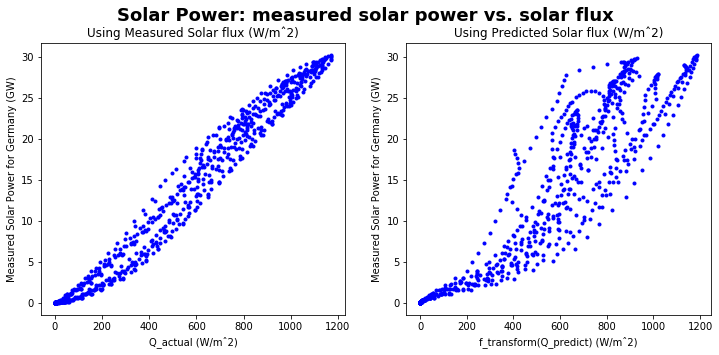

In [52]:
fig,axes= plt.subplots(1,2,figsize=(12,5))
axes[0].plot(rad_solarpower.mean_rad_meas,rad_solarpower.solar,'b.')
axes[1].plot(func(rad_solarpower.mean_rad_pred,*popt),rad_solarpower.solar,'b.')
plt.suptitle('Solar Power: measured solar power vs. solar flux',fontsize=18,fontweight='bold')
axes[0].title.set_text("Using Measured Solar flux (W/mˆ2)")
axes[1].title.set_text("Using Predicted Solar flux (W/mˆ2)")
axes[0].set(xlabel='Q_actual (W/mˆ2)',ylabel='Measured Solar Power for Germany (GW)')
axes[1].set(xlabel='f_transform(Q_predict) (W/mˆ2)',ylabel='Measured Solar Power for Germany (GW)')


In [53]:
radPowerPredict = rad_solarpower\
                  .join(radPredict,how='outer')\
                  .interpolate(limit_direction='both')\
                  .reindex(index=radPredict.index)

In [54]:
radPowerPredict.drop(columns=['mean_rad_pred','mean_rad_meas'],inplace=True)

In [55]:
radPowerPredict

,solar,Bremen,Chemnitz,Fichtelberg,Furstenzell,Gorlitz,Hamburg,Hohenpeissenberg,Konstanz,Lindenberg,Norderney,Potsdam,Rostock,Saarbrucken,Schleswig,Seehausen,Trier,Wuerzburg,morning
2019-06-20 14:00:00+00:00,18.553,581.517028,720.483938,722.154871,213.630218,356.088289,341.515014,172.736746,587.945066,584.435221,341.760910,717.965704,340.702881,586.701840,340.760925,403.272683,344.797619,344.354401,0.0
2019-06-20 15:00:00+00:00,16.391,574.874695,709.808479,590.701964,210.361996,350.206422,337.309159,170.417451,580.904931,671.522868,338.295759,707.326660,335.947625,580.712656,336.694705,397.736088,716.897178,340.061646,0.0
2019-06-20 16:00:00+00:00,13.197,329.892315,689.029254,560.167236,236.914423,326.083894,433.255255,165.706528,496.080362,576.243652,330.606453,686.737949,326.626264,645.497422,328.278707,570.328033,333.614429,331.172091,0.0
2019-06-20 17:00:00+00:00,10.089,536.632199,778.223123,782.827552,224.277577,308.123332,572.967008,157.543269,317.603127,784.639754,317.255837,651.978099,310.934768,581.888165,533.702316,542.938942,543.842329,315.799222,0.0
2019-06-20 18:00:00+00:00,7.539,613.671988,594.571571,713.988358,202.783147,278.034107,492.611471,143.645307,612.199403,717.643662,295.314237,594.384052,285.242322,622.025955,162.697291,497.744835,296.881955,289.965406,0.0
2019-06-20 19:00:00+00:00,4.408,530.843491,491.194292,593.139578,141.358979,391.752119,523.170559,123.529668,613.036758,600.715478,258.771232,495.387316,411.449638,536.410579,161.030973,367.632050,437.246814,416.314768,0.0
2019-06-20 20:00:00+00:00,1.864,383.059866,239.804188,145.278025,76.060468,217.829306,371.229345,72.742508,263.645724,380.011774,194.641905,313.481224,346.772570,375.990043,117.437603,245.854986,312.118162,271.490199,0.0
2019-06-20 21:00:00+00:00,0.247,95.836982,5.143378,2.764337,0.018762,0.763676,104.415634,0.767669,10.659506,5.021071,108.811759,27.082373,75.093036,76.292932,71.933484,27.544547,78.309980,31.046625,0.0
2019-06-20 22:00:00+00:00,0.001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2019-06-20 23:00:00+00:00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [56]:
#cols = [ *cities, 'morning']
cols = [*cities]
reg= linear_model.LinearRegression()
reg.fit(X=radPowerPredict[cols],y=radPowerPredict.solar)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
radPowerPredict['solar_pred'] = reg.predict(radPowerPredict[cols])
radPowerPredict.solar_pred[radPowerPredict.solar_pred < 0] = 0

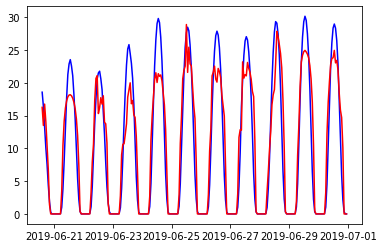

In [58]:
plt.plot(radPowerPredict.index,radPowerPredict.solar,'b-')
plt.plot(radPowerPredict.index,radPowerPredict.solar_pred,'r-')

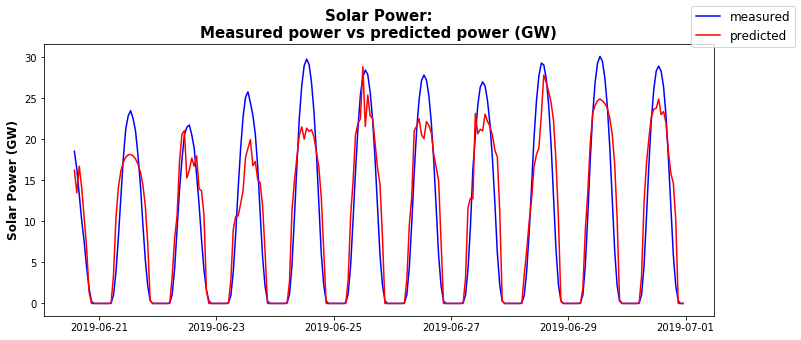

In [59]:
plt.figure(figsize=(12,5))
plt.plot(radPowerPredict.index,radPowerPredict.solar,'b-',label='measured')
plt.plot(radPowerPredict.index,radPowerPredict.solar_pred,'r-',label='predicted')
plt.title("Solar Power:\nMeasured power vs predicted power (GW)",fontdict=titlefont)
plt.ylabel("Solar Power (GW)",fontdict=axisfont)
plt.figlegend(fontsize=12)
plt.show()

In [62]:
r2_score(radPowerPredict.solar,radPowerPredict.solar_pred)

0.865974247558476

In [73]:
radPowerPredict.solar.min()

0.0

In [74]:
clientDF.close()